In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import AlexNet_Weights
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)

caltech_data = datasets.Caltech256(
    root="dataset",
    transform=ToTensor(),
    download = True
)

cuda:0
Files already downloaded and verified


In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
data_dir = "dataset/caltech256/256_ObjectCategories" 
dataset = datasets.ImageFolder(data_dir, transforms_train)

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
test_size = int(0.5 * len(test_dataset))
val_size = len(test_dataset) - test_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

In [6]:
print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 24488
Validation dataset size: 3062
Test dataset size: 3061


In [7]:
class_names = dataset.classes
class_num = len(class_names)
print("Number of classes: ", class_num)

Number of classes:  257


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=12, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12)

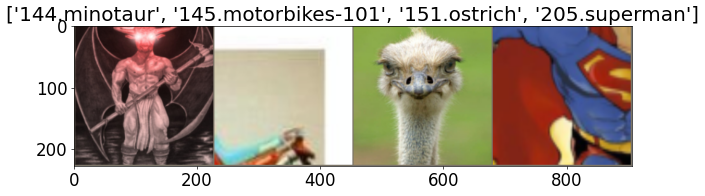

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()# load a batch of train image
iterator = iter(train_dataloader)# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [10]:
model = models.alexnet(weights = AlexNet_Weights.IMAGENET1K_V1)   
model_stripped = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(device)
model_stripped.to(device)
# Create a sample input tensor
input_size = (3, 224, 224)
input_tensor = torch.randn(1, *input_size).to(device)

# Use torchsummary to print the model summary
summary(model, input_size=input_size)
summary(model_stripped, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [11]:
print(model.classifier)
model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)


In [12]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [13]:
normal_model = model

normal_model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)],
                                       nn.Linear(4096, class_num))
print(normal_model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): Linear(in_features=4096, out_features=257, bias=True)
)


In [14]:
normal_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_accuracy.png'))
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_loss.png'))

In [16]:
from tqdm import tqdm

def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [17]:
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
epochs = 30
batch_size = 12
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.Adam(normal_model.parameters(), lr=learning_rate)

[INFO]: Epoch 1 of 30
Training


100%|██████████| 2041/2041 [00:16<00:00, 121.32it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.77it/s]

Training loss: 430.438, training acc: 24.404 %
Validation loss: 369.875, validation acc: 35.826 %
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.58it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.16it/s]

Training loss: 434.173, training acc: 34.376 %
Validation loss: 374.212, validation acc: 39.647 %
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.93it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 125.29it/s]

Training loss: 451.585, training acc: 38.006 %
Validation loss: 402.321, validation acc: 40.954 %
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 120.99it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.50it/s]

Training loss: 458.480, training acc: 39.456 %
Validation loss: 407.184, validation acc: 42.913 %
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.85it/s]

Validation



100%|██████████| 256/256 [00:01<00:00, 131.42it/s]

Training loss: 460.352, training acc: 40.730 %
Validation loss: 425.413, validation acc: 41.541 %
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.15it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 123.32it/s]

Training loss: 466.436, training acc: 41.804 %
Validation loss: 425.595, validation acc: 42.782 %
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.39it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 125.59it/s]

Training loss: 459.996, training acc: 42.829 %
Validation loss: 388.136, validation acc: 46.865 %
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.68it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 123.14it/s]

Training loss: 464.625, training acc: 43.233 %
Validation loss: 439.838, validation acc: 44.775 %
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.78it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.67it/s]

Training loss: 463.851, training acc: 43.429 %
Validation loss: 448.192, validation acc: 44.513 %
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.73it/s]


Validation


100%|██████████| 256/256 [00:02<00:00, 123.02it/s]

Training loss: 465.220, training acc: 44.495 %
Validation loss: 457.036, validation acc: 45.330 %
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.61it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 127.15it/s]

Training loss: 466.343, training acc: 44.536 %
Validation loss: 437.411, validation acc: 46.114 %
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.62it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.73it/s]

Training loss: 457.696, training acc: 44.998 %
Validation loss: 441.292, validation acc: 46.767 %
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training



100%|██████████| 2041/2041 [00:17<00:00, 119.55it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.57it/s]

Training loss: 459.602, training acc: 45.198 %
Validation loss: 465.580, validation acc: 45.265 %
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.77it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.33it/s]

Training loss: 462.869, training acc: 45.745 %
Validation loss: 436.407, validation acc: 48.269 %
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.76it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.77it/s]


Training loss: 465.139, training acc: 45.737 %
Validation loss: 455.261, validation acc: 47.224 %
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


100%|██████████| 2041/2041 [00:16<00:00, 120.31it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 123.50it/s]

Training loss: 456.734, training acc: 46.455 %
Validation loss: 422.401, validation acc: 48.367 %
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.40it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 126.54it/s]

Training loss: 458.610, training acc: 46.602 %
Validation loss: 455.812, validation acc: 45.493 %
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.30it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 123.94it/s]


Training loss: 459.084, training acc: 46.929 %
Validation loss: 487.055, validation acc: 46.930 %
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


100%|██████████| 2041/2041 [00:16<00:00, 122.42it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.14it/s]

Training loss: 459.940, training acc: 46.627 %
Validation loss: 432.841, validation acc: 48.334 %
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.29it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 125.15it/s]

Training loss: 458.406, training acc: 46.843 %
Validation loss: 451.401, validation acc: 46.342 %
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 120.49it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 119.96it/s]

Training loss: 462.046, training acc: 46.782 %
Validation loss: 467.884, validation acc: 46.342 %
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.85it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 126.09it/s]

Training loss: 460.229, training acc: 46.770 %
Validation loss: 430.424, validation acc: 49.477 %
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 120.77it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.88it/s]

Training loss: 452.731, training acc: 47.464 %
Validation loss: 445.542, validation acc: 48.792 %
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 120.96it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 121.18it/s]

Training loss: 453.273, training acc: 47.766 %
Validation loss: 439.802, validation acc: 49.379 %
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.98it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 120.21it/s]

Training loss: 454.177, training acc: 47.995 %
Validation loss: 456.562, validation acc: 48.204 %
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.10it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 126.07it/s]


Training loss: 453.572, training acc: 47.901 %
Validation loss: 485.114, validation acc: 47.355 %
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


100%|██████████| 2041/2041 [00:16<00:00, 122.38it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 122.20it/s]

Training loss: 451.034, training acc: 47.852 %
Validation loss: 440.330, validation acc: 49.053 %
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 122.44it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.56it/s]

Training loss: 453.753, training acc: 48.264 %
Validation loss: 459.437, validation acc: 48.988 %
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training



100%|██████████| 2041/2041 [00:17<00:00, 119.90it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 121.04it/s]

Training loss: 453.293, training acc: 48.473 %
Validation loss: 467.226, validation acc: 48.465 %
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training



100%|██████████| 2041/2041 [00:16<00:00, 121.35it/s]

Validation



100%|██████████| 256/256 [00:02<00:00, 124.02it/s]


Training loss: 445.984, training acc: 48.579 %
Validation loss: 473.161, validation acc: 47.910 %
--------------------------------------------------
TRAINING COMPLETE


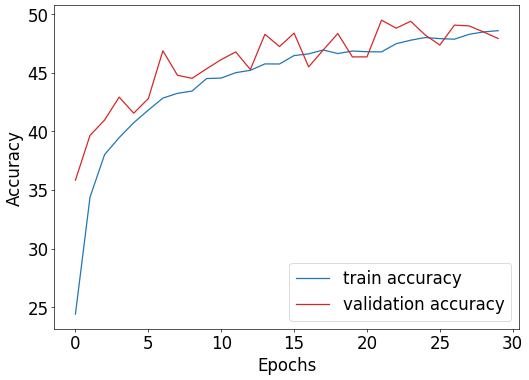

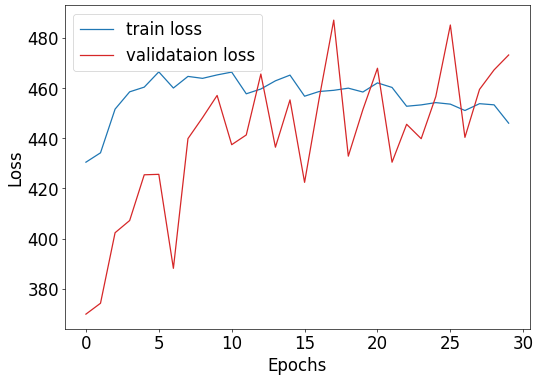

In [19]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
plot_name = 'alexnet'

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        normal_model, 
        train_dataloader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        normal_model, 
        val_dataloader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f} %")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f} %")
    print('-'*50)

# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')

In [20]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
   

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j], f'predicted: {class_names[preds[j]]} vs real: {class_names[labels[images_so_far-1]]}')
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

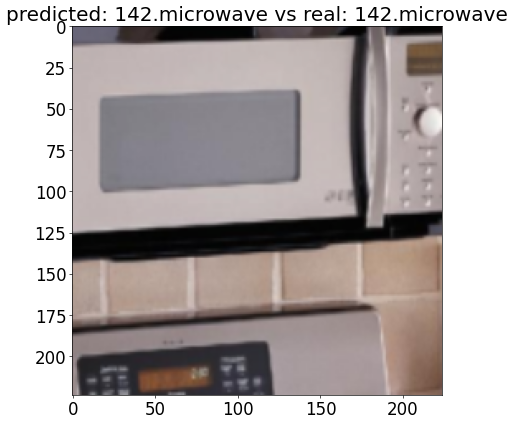

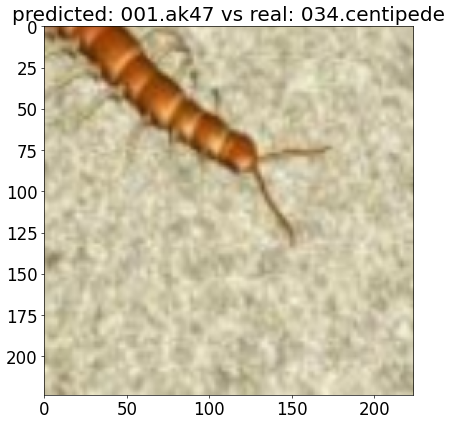

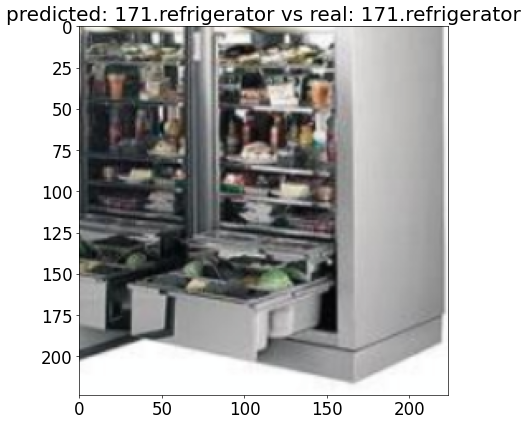

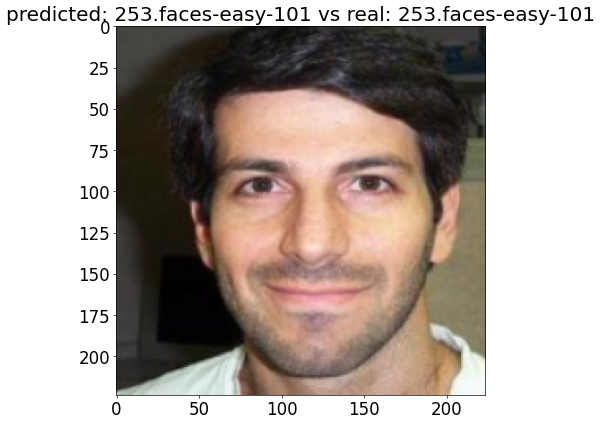

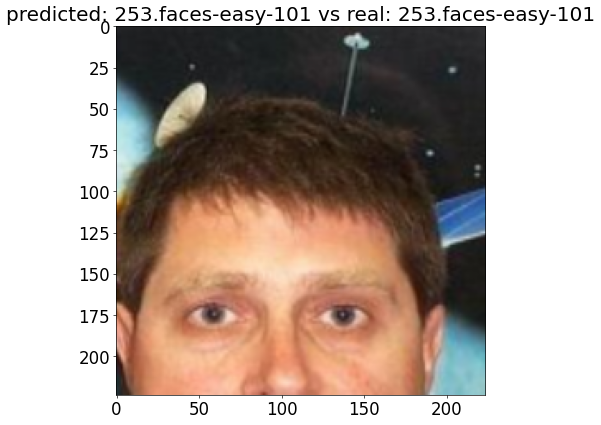

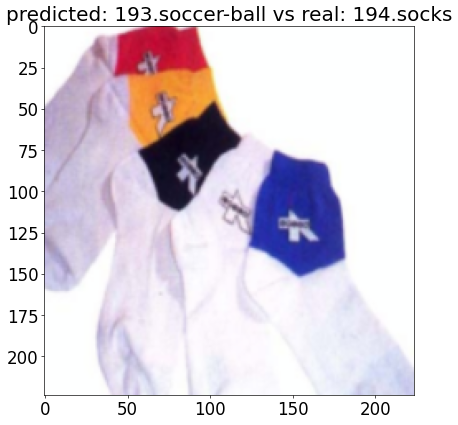

In [21]:
visualize_model(normal_model, val_dataloader)

In [22]:
def test(model, testloader, device):
    model.eval()
    print('Testing')
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
        print(f'Accuracy of the network on test images: {100 * (correct / total):.3f} %')

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test(normal_model, test_dataloader, device)

Testing
Accuracy of the network on test images: 48.350 %


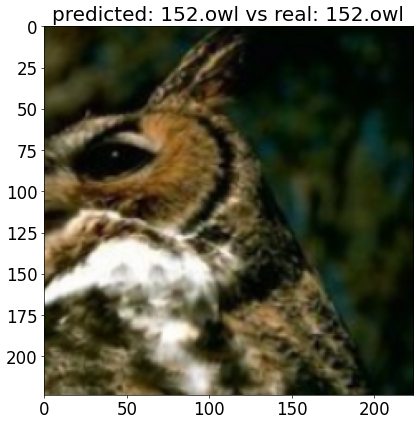

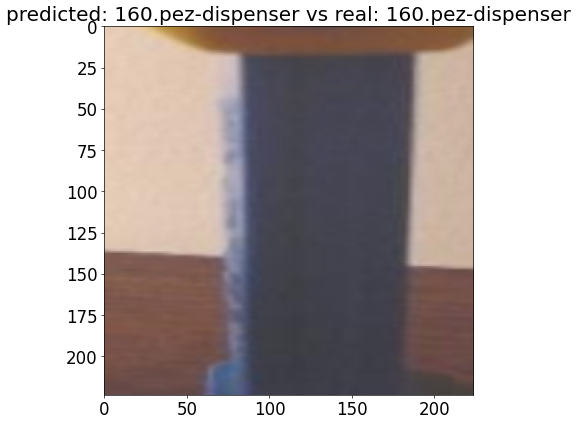

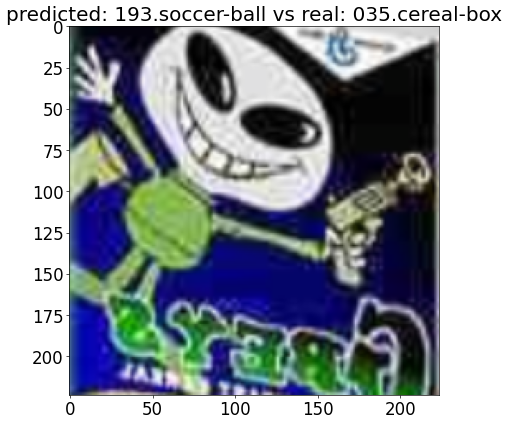

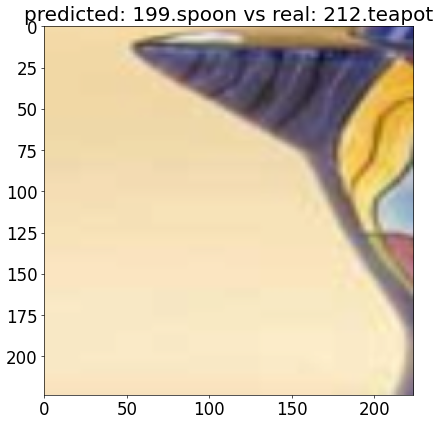

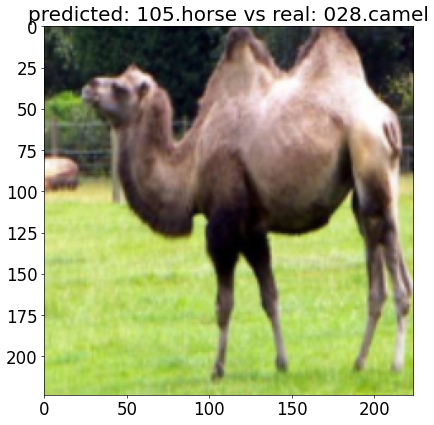

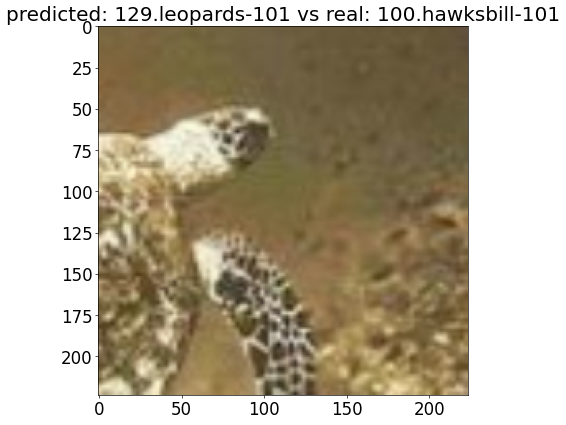

In [24]:
visualize_model(normal_model, test_dataloader)

In [25]:
knn_model = model
knn_model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
knn_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
features = []
f_labels = []

for i, data in enumerate(train_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = knn_model(image)
    
    for j in range(image.size()[0]):
        features.append(batch_features[j].cpu().numpy())
        f_labels.append(labels[j].cpu().numpy())

print(len(features))   

24488


In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(features, f_labels)

KNeighborsClassifier(n_neighbors=12)

In [48]:
val_features = []
val_labels = []

for i, data in enumerate(val_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = knn_model(image)
    
    for j in range(image.size()[0]):
        val_features.append(batch_features[j].cpu().numpy())
        val_labels.append(labels[j].cpu().numpy())

print(val_features[0])
print(len(val_features))   

[-1.155575    1.2723517   0.54868615 ... -4.9886327  -3.8010352
 -2.3288112 ]
3062


In [49]:
pred = knn.predict(val_features)

In [50]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(val_labels, pred)
print("Accuracy:", accuracy)

Accuracy: 0.42913128674069234


In [51]:
summary(knn_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [52]:
test_features = []
test_labels = []

for i, data in enumerate(test_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = knn_model(image)
    
    for j in range(image.size()[0]):
        test_features.append(batch_features[j].cpu().numpy())
        test_labels.append(labels[j].cpu().numpy())

pred = knn.predict(test_features)
accuracy = accuracy_score(test_labels, pred)
print("Knn test accuracy:", accuracy)

Knn test accuracy: 0.430578242404443
